# RADIA Example 5: Iron-Dominated Electromagnet

This example illustrates the use of Radia for simulating an iron-dominated
dipole electromagnet.

The magnetic field at any point in space results from two contributions:
one from real sources of magnetic field, such as coils or permanent magnets;
and a second from the magnetization of any iron present.
Although the iron’s magnetization is induced by the coils or permanent magnets,
its field contribution can be much larger than that of the direct contribution
from coils and permanent magnets.
We call such geometries _iron dominated_.
The dipole and quadrupole electromagnets typically used in particle accelerators
fall into this category, whereas most undulators and wigglers used as sources of
synchrotron radiation do not.

Field computations in the case of iron-dominated geometries present specific
difficulties that usually make them less accurate than those in the case of
structures dominated by coils or permanent magnets. Nevertheless, Radia
includes special methods that enable one to obtain reasonable precision
with a reasonable amount of computational effort—cpu time and memory usage.

The example presented here is that of a simple dipole steerer:
A closed circuit of iron with a small gap has a coil wound around the circuit;
and that coil drives flux in the iron (see the graphics below).
This example is more sensitive than all the previous examples, and we advise
the beginner to gain experience with those earlier examples before diving into
this one. 

The following recommendations will help you achieve an acceptable level
of precision within a reasonable time:

* Segment the corners of iron circuits as parallel or as perpendicular
as possible to lines of magnetic flux. For right-angled corners, one can
do this using the circular or ellipsoidal mode of segmentation (see below). 
Following this recommendation will have a significant impact on your
simulations of iron-dominated electromagnets.

    In the example shown here, we provide (for the sake of comparison)
the option to use circular (the default) or square segmentation
for the corners. See the function `create_dipole(..)` in the section
below entitled **_Define a general function to build a dipole steering magnet_**,
and look for the lines containing

```
rad.ObjDivMag(g3, [ncr, nca, n3[1]], 'cyl', typ)
```

    and
    
```
rad.ObjDivMag(g5, [ncr, nca, n5[0]], 'cyl', typ)
```

* Use a finer segmentation for the iron regions (particularly the pole
pieces) closest to the region of interest. 

* Start with a coarse segmentation and gradually make it finer until
the computed field values are stable.
Be aware that both memory usage and cpu time tend to increase as the
square number of elements (segments) in the iron.

* To the greatest extent possible, take advantage of any symmetries
present in your system. Doing so saves both memory usage and CPU time.
The steering dipole shown in this example has two planes of symmetry,
which allow one to reduce the overall problem size by a factor of
2$\,\times\,$2. As a consequence, taking advantage of the symmetries
in this example means one can cut by a factor of 16 both the memory
usage and the cpu time required to reach a solution.

As in the previous examples, experiment with modifying various
parameters and explore how such changes affect the time to solution
and the solution itself.
Keep in mind that memory usage and cpu time are roughly proportional
to the square of the number of sub-elements. This means that increasing
the segmentation by a factor of 2 in all three dimensions results in an
8-fold increase in the number of sub-elements, and a 64-fold increase
in both memory usage and cpu time. As a consequence, it pays to refine
the segmentation in some “intelligent” manner. Doing so requires some
experience, but the general rule is to concentrate refinements to
where it matters most: generally where the field is changing most
rapidly—in magnitude or direction—and (especially) closest to regions
of interest.

In particular, you might keep track of the precision as you increase
the segmentation along one direction and in one object at a time.
Following this procedure, you can quickly identify those objects
and directions for which refinment yields the most significant
improvements to precision.

For an explanation of all Radia functions, see the
[Radia Reference Guide](
  https://www.esrf.eu/Accelerators/Groups/InsertionDevices/Software/Radia/Documentation/ReferenceGuide/Index
  "RADIA Reference Guide at ESRF").

## _Import Radia and other packages_

In [1]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import scipy.constants as sc
import numpy as np
import time as tm

%matplotlib inline
import ipywidgets
#import radia as rad
import radia
from jupyter_rs_radia import radia_viewer

The following figure illustrates the simple dipole steering magnet
simulated in this example.

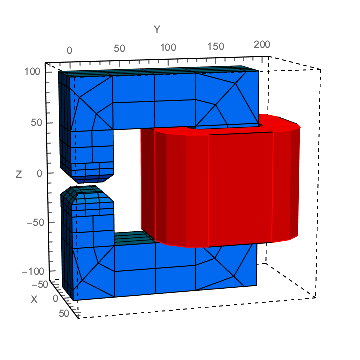

In [2]:
# import an illustration of this magnet
from IPython.display import Image
Image(filename=('./SimpleDipole.png'))

## _Define a general function to build a dipole steering magnet_

Here we define a function that creates the dipole steering magnet
of this example. The various arguments (detailed in the function’s
docstring) specify the geometry, material properties, current, and 
segmentation of this model magnet.

In [20]:
def create_dipole(gap, thick, width, chamfer, lpp, lap, lha, car, iron,
                  rmin, rmax, current,
                  n1, n2, n3, n4, n5, n6, ncr, nca, nsc,
                  circ = True):
    """
    create a simple dipole electromagnet
    arguments:
        gap     = distance between iron pole tips / mm
        thick   = thickness of iron pole tip (along particle trajectory) / mm
        width   = width of iron pole tip (transverse to particle trajectory) / mm
        chamfer = size of chamfer on iron pole tip / mm
        lpp     = length of pole piece / mm
        lap     = length of segment above the pole piece / mm
        lha     = length of horizontal arm (between the corners) / mm
        car     = corner aspect ratio
        iron    = material specification of the iron
        rmin    = minimum coil radius / mm
        rmax    = maximum coil radius / mm
        current = coil current / A
        n1      = segmentation parameters for pole tip
        n2      = segmentation parameters for vertical segment above pole tip
        n3      = segmentation parameters for corner above pole tip
        n4      = segmentation parameters for horizontal segment between corners
        n5      = segmentation parameters for other corner
        n6      = segmentation parameters for vertical segment inside coil
        ncr     = number of radial segments in the iron corners
        nca     = number of azimuthal segments in the iron corners
        nsc     = number segments in coil corners
        circ    = whether to use cicular segmentation at iron corners (boolean)
    return Radia representation of a simple dipole steering magnet
    """
    # global quantities
    global g1, g2, g3, g4, g5, g6
    global yoke, coil

    # debug parameter
    eps = 0

    # colors
    iron_color = [0.0, 0.5, 1.0]
    coil_color = [1.0, 0.0, 0.0]

    # yoke geometry

    # -- pole piece
    lx1 = thick / 2
    ly1 = width
    lz1 = lpp  # height of pole piece above pole tip / mm
    l1  = [lx1, ly1, lz1]
    k1  = [[thick / 4. - chamfer / 2., 0, gap / 2.],
           [thick / 2. - chamfer, ly1 - 2. * chamfer]]
    k2  = [[thick / 4., 0., gap / 2. + chamfer], [thick / 2., ly1]]
    k3  = [[thick / 4., 0., gap / 2. + lz1],     [thick / 2., ly1]]
    g1  = radia.ObjMltExtRtg([k1, k2, k3])
    radia.ObjDivMag(g1, n1)

    # -- vertical segment above pole piece
    lx2 = thick / 2
    ly2 = ly1
    lz2 = lap
    l2  = [lx2, ly2, lz2]
    p2  = [thick / 4, 0, gap / 2 + lz1 + lz2 / 2 + eps]
    g2  = radia.ObjRecMag(p2, l2)
    radia.ObjDivMag(g2, n2)

    # -- corner above pole piece
    lx3 = thick / 2
    ly3 = ly2
    lz3 = car * ly2
    l3  = [lx3, ly3, lz3]
    p3  = [thick / 4, 0, gap / 2 + lz1 + lz2 + lz3 / 2 + 2 * eps]
    g3  = radia.ObjRecMag(p3, l3)
    #    parameters for circular segmentation
    typ = [[p3[0], p3[1] + ly3 / 2, p3[2] - lz3 / 2], [1, 0, 0],
           [p3[0], p3[1] - ly3 / 2, p3[2] - lz3 / 2], lz3 / ly3]
    #   circular or rectangular segmentation
    if circ:
        radia.ObjDivMag(g3, [ncr, nca, n3[0]], 'cyl', typ)
    else:
        radia.ObjDivMag(g3, n3)

    # -- horizontal segment between corners
    lx4 = thick / 2
    ly4 = lha
    lz4 = lz3
    l4  = [lx4, ly4, lz4]
    p4  = [thick / 4, ly3 / 2 + ly4 / 2 + eps, p3[2]]
    g4  = radia.ObjRecMag(p4, l4)
    radia.ObjDivMag(g4, n4)

    # -- other corner (above coil)
    lx5 = thick / 2
    ly5 = car * lz4
    lz5 = lz4
    l5  = [lx5, ly5, lz5]
    p5  = [thick / 4, p4[1] + (ly4 + ly5) / 2 + eps, p4[2]]
    g5  = radia.ObjRecMag(p5, l5)
    #    parameters for circular segmentation
    typ = [[p5[0], p5[1] - ly5 / 2, p5[2] - lz5 / 2], [1, 0, 0],
           [p5[0], p5[1] + ly5 / 2, p5[2] - lz5 / 2], lz5 / ly5]
    #    circular or square segmentation
    if circ:
        radia.ObjDivMag(g5, [ncr, nca, n5[0]], 'cyl', typ)
    else:
        radia.ObjDivMag(g5, n5)

    # -- vertical segment inside coil
    lx6 = thick/2
    ly6 = ly5
    lz6 = gap/2 + lz1 + lz2
    l6  = [lx6, ly6, lz6]
    p6  = [thick/4, p5[1], p5[2] - (lz6 + lz5)/2 - eps]
    g6  = radia.ObjRecMag(p6, l6)
    radia.ObjDivMag(g6, n6)

    # group iron pieces into a single yoke, set material properties, ...
    yoke = radia.ObjCnt([g1, g2, g3, g4, g5, g6])
    radia.MatApl(yoke, iron)
    # and set color
    radia.ObjDrwAtr(yoke, iron_color)

    # add geometry with a name for viewing
    # rv.add_geometry('pole piece',                   g1)
    # rv.add_geometry('short vertical segment',       g2)
    # rv.add_geometry('corner 1',                     g3)
    # rv.add_geometry('horizontal segment',           g4)
    # rv.add_geometry('corner 2',                     g5)
    # rv.add_geometry('vertical segment inside coil', g6)
    # rv.add_geometry('iron yoke',                  yoke)

    # apply symmetry conditions
    radia.TrfZerPerp(yoke, [0, 0, 0], [1, 0, 0])  # across y-z plane, with B parallel to plane
    radia.TrfZerPara(yoke, [0, 0, 0], [0, 0, 1])  # across x-y plane, with B perpendicular to plane

    # coil geometry, current, ...
    hc = 2 * lz6 - rmin
    curr_dens = current / (hc * (rmax - rmin))
    pc = [0, p6[1], 0]
    coil = radia.ObjRaceTrk(pc, [rmin, rmax], [thick, ly6], hc, nsc, curr_dens)
    # and color
    radia.ObjDrwAtr(coil, coil_color)
    # rv.add_geometry('coil', coil)

    # group yoke and coil together, and return
    return radia.ObjCnt([yoke, coil])

    # end create_dipole(..)

## _Create the dipole and solve for the fields_

First set the various parameters that specify the properties—geometry,
materials, and current—of our dipole. Then also decide how finely to
segment the iron.

In [4]:
# dipole parameters
# -- yoke geometry (all lengths in mm)
gap     = 10  # between pole tips
thick   = 50  # thickness of iron pole piece (along trajectory)
width   = 40  # width of iron pole piece (transverse to trajectory)
chamfer =  8  # size of chamfer on iron pole piece
lpp     = 20  # length of pole piece (includes chamfer)
lap     = 30  # length of arm above pole piece
lharm   = 80  # length of horizontal arm between the corners
cratio  = 1.25  # corner aspect ratio (H:W in corner 1; W:H in corner 2)
# -- yoke material
ironmat = radia.MatSatIsoFrm([20000, 2], [0.1, 2], [0.1, 2])
# -- coil geometry
rmin =  5
rmax = 40
# -- coil current
current = -2000  # A

# segmentation parameters
# -- yoke sections
nx = 2
n1 = [nx, 3, 2] # pole face
n2 = [nx, 2, 2] # small vertical arm
n3 = [nx, 2, 2] # corner above pole
n4 = [nx, 2, 2] # horizontal arm
n5 = [nx, 2, 2] # other corner (above coil)
n6 = [nx, 2, 2] # long vertical arm (inside the coil)
# -- for circular segmentation: yoke corners and coil arcs
ncr = 2 # number of radial segments in yoke corners
nca = 2 # number of azimuthal segments in yoke corners
nsc = 3 # number of segments in coil arcs

Now simulate this dipole steering magnet:

In [21]:
# build the dipole
dipole = create_dipole(gap, thick, width, chamfer, lpp, lap, lharm, cratio, ironmat,
                       rmin, rmax, current,
                       n1, n2, n3, n4, n5, n6, ncr, nca, nsc,
                       circ = True)

# define and show the radia viewer
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Simple Dipole Steerer', dipole)
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

Need some means of reading ... the output of radia.Solve().
The $B_z$ field at the origin, $(0, 0, 0)$, is the vertical field in the middle of the gap.

In [6]:
t0 = tm.time()
dipole = create_dipole(gap, thick, width, chamfer, lpp, lap, lharm, cratio, ironmat,
                       rmin, rmax, current,
                       n1, n2, n3, n4, n5, n6, ncr, nca, nsc,
                       circ = True)
t1 = tm.time()
res = radia.Solve(dipole, 0.0001, 1500)
t2  = tm.time()

print("built in  ", t1 - t0, " seconds")
print("solved in ", t2 - t1, " seconds")

size    = radia.ObjDegFre(dipole)
b0      = radia.Fld(dipole, 'Bz', [0, 0, 0])
bampere = (- 4 * np.pi * current / gap) / 10000

print("interaction matrix: ", size, " x ", size, " .equiv. ", (4 * size * size / 1000000), " MBytes")
print("Mag_max  = ",  res[1], " T")
print("H_max    = ",  res[2], " T")
print("num_iter = ",  int(res[3]))
print("Bz(origin) = ", b0, " T")
print("Bz computed / Bz Ampère law  = ", b0 / bampere)

built in   0.0030837059020996094  seconds
solved in  0.11108183860778809  seconds
interaction matrix:  216  x  216  .equiv.  0.186624  MBytes
Mag_max  =  0.9307456707226021  T
H_max    =  5.0414124933694746e-05  T
num_iter =  665
Bz(origin) =  0.25802211731275304  T
Bz computed / Bz Ampère law  =  1.0266373849340389


### _possible explorations_

In this example computation, we have used a coarse subdivision of the
iron in order to realize a short CPU time. Of course this comes at
the cost of reduced precision. The excitation current of –2000&#8239;A
is relatively low, and the iron used in this example has a very large
permeability. As a consequence, the iron does not saturate and Ampère’s
law yields a good estimate of the on-axis field. Discrepancies between
the computed and Ampère law estimate derive from the coarse segmentation
and the small residual deviations from field uniformity in the gap. For
better agreement, you might modify the segmentation parameters to read
```
nx = 3
n1 = [nx, 3, 2]
n2 = [nx, 3, 3]
n4 = [nx, 3, 3]
n6 = [nx, 3, 3]
ncr = 3
nca = 3
```
The CPU time will increase, but should still be reasonable.

You can explore the effects of saturation in the iron by either
increasing the coil current (_e.g._, `current = -10000`), using
a lower saturated magnetization when calling `MatSatIsoFrm`, or
specifying a different material for the iron yoke.
The computed values `Mag_max` and  `H_max` give the maximum values
in the iron circuit of the magnetization vector, $\vec{M}$, and the
magnetic field vector, $\vec{H}$, both expressed in Tesla.
If saturation occurs somewhere in the circuit, `Mag_max` will approach
the saturated magnetization of the material (in this example 2&#8239;T,
as defined in `MatSatIsoFrm`), and `H_max` will deviate from 0.

You can also explore the effects of modifying details of the magnet
geometry—especially the parameters `gap`, `thick`, `width`, and `chamfer`
that define the pole. Of course you may need to modify the segmentation
parameters accordingly in order to obtain an acceptable precision
within a reasonable CPU time.
The only risk is that specifying too fine a segmentation will tax
the available memory on your system. In the worst case, you will have
to restart the Kernel, adjust the segmentation, and then re-execute
all sections of this notebook.

You may estimate the memory requirement by looking at the size of the
interaction matrix.

In the following sections, you will see how to plot the field and field
integrals at locations of interest.

## _Plots of the magnetic field and field integrals_

Here we show plots of magnetic field in the gap and corresponding
field integrals. The field values are obtained by calling `FldLst`

Each graph corresponds to the field created by the whole steerer.
It is possible to compute separately the contributions from the coil
and from the iron. To do so, one simply calls `FldLst` with `coil`
or `yoke` as the first argument, instead of `dipole`. It is also
possible to compute the contribution from each part of the iron
circuit by setting the first argument of `FldLst` to one of `g1`,
`g2`, ..., `g6`. For these elements, however, one must account for
the fact that the magnet symmetries were applied only to the whole
container `yoke`, and not to the individual elements `g1`, `g2`,
..., `g6`. As a consequence, one must multiply the contribution
from any of those latter elements by a factor of
2&#8239;x&#8239;2&#8239;=&#8239;4.

Even though the field produced by the whole magnet is the sum of
coil field plus 4 times the field from `g1` plus `g2` plus ...
plus `g6`, the magnetization of any of the iron elements `g#`
depends on the magnetization of all the other elements.
Nevertheless, it can be very quite interesting to explore which
parts of the magnetized iron circuit contribute most to the field
in the gap, as well as to examine the field gradient. 

In [9]:
dipole

351

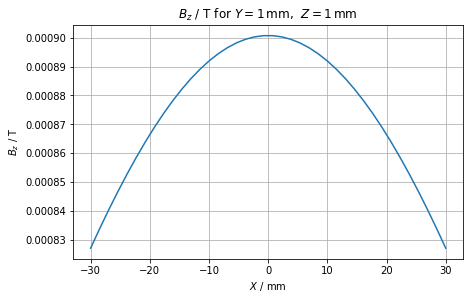

In [22]:
xmax = 30
y  = 1
z  = 1
num_points = 40

xv = np.linspace(-xmax, xmax, num_points)
bz = radia.FldLst(dipole, 'bz', [-xmax, y, z], [xmax, y, z], num_points,
                  "noarg", -xmax)

plt.figure(figsize=(7,4.3))
plt.plot(xv, bz)
plt.title(r'$B_z$ / T for $Y = 1\,\mathrm{mm}$,  $Z = 1\,\mathrm{mm}$')
plt.xlabel(r'$X$ / mm')
plt.ylabel(r'$B_z$ / T')
plt.grid()
plt.show()

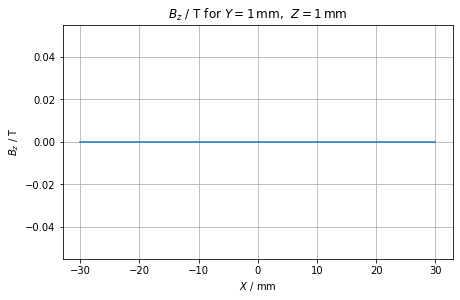

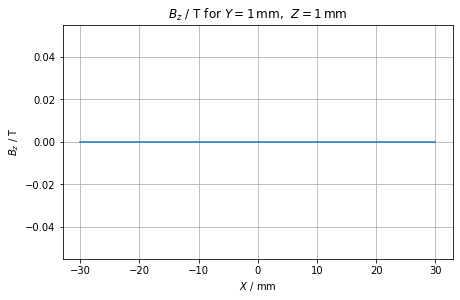

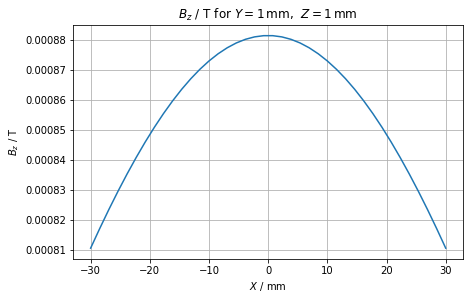

In [25]:
xmax = 30
y  = 0
z  = 0
num_points = 40

xv  = np.linspace(-xmax, xmax, num_points)
bzy = radia.FldLst(yoke, 'bz', [-xmax, y, z], [xmax, y, z], num_points,
                   "noarg", -xmax)
bzc = radia.FldLst(coil, 'bz', [-xmax, y, z], [xmax, y, z], num_points,
                   "noarg", -xmax)
bg1 = radia.FldLst(g1, 'bz', [-xmax, y, z], [xmax, y, z], num_points,
                   "noarg", -xmax)

plt.figure(figsize=(7,4.3))
plt.plot(xv, bg1)
plt.title(r'$B_z$ / T for $Y = 1\,\mathrm{mm}$,  $Z = 1\,\mathrm{mm}$')
plt.xlabel(r'$X$ / mm')
plt.ylabel(r'$B_z$ / T')
plt.grid()
plt.show()

plt.figure(figsize=(7,4.3))
plt.plot(xv, bzy)
plt.title(r'$B_z$ / T for $Y = 1\,\mathrm{mm}$,  $Z = 1\,\mathrm{mm}$')
plt.xlabel(r'$X$ / mm')
plt.ylabel(r'$B_z$ / T')
plt.grid()
plt.show()

plt.figure(figsize=(7,4.3))
plt.plot(xv, bzc)
plt.title(r'$B_z$ / T for $Y = 1\,\mathrm{mm}$,  $Z = 1\,\mathrm{mm}$')
plt.xlabel(r'$X$ / mm')
plt.ylabel(r'$B_z$ / T')
plt.grid()
plt.show()

In [ ]:
?radia.FldLst

## _Magnetic force_

One computes the force over the element g1 induced by the whole structure. One should be cautious that the cpu time to compute the force can be very long and one must set the segmentation parameter k to the lowest values consistent with   sufficient precision . Taking into account the symmetry with respect to the x axis {1,0,0}  would remove the Fx component and double the Fy and Fz components. 

```
k={1,1,2};
t1=AbsoluteTime[];
fr=radFldEnrFrc[g1,t,"",k];
t2=AbsoluteTime[];
Print["{Fx, Fy, Fz} = ",N[fr,3]," Newton"];
Print ["cpu time : ",N[t2-t1,3]," seconds"];
```

In [38]:
k = [1, 1, 2]

t0 = tm.time()
fx = radia.FldEnrFrc(g1, dipole, 'fx', [1, 1, 2])
fy = radia.FldEnrFrc(g1, dipole, 'fy', [1, 1, 2])
fz = radia.FldEnrFrc(g1, dipole, 'fz', [1, 1, 2])
t2 = tm.time()

print("[Fx, Fy, Fz] = ", [fx, fy, fz], " N")
print("cpu time: ", t1 - t0," s")

[Fx, Fy, Fz] =  [0.0, 0.0, 0.0]  N
cpu time:  -5513.438322544098  s


## _Comparison of results obtained with rectangular segmentation in the corners_

The same model is created but the segmentation in the corner is made with parallelepipedic sub-elements. The precision of the field in the gap is much poorer. It can be improved by using larger values of n3 and n5 such as {nx,4,4} or {nx,6,6},  but the CPU time and memory requirements grow  quickly.

In [39]:
# build the dipole
dipole = create_dipole(gap, thick, width, chamfer, lpp, lap, lharm, cratio, ironmat,
                       rmin, rmax, current,
                       n1, n2, n3, n4, n5, n6, ncr, nca, nsc,
                       circ = False)

# define and show the radia viewer
rv = radia_viewer.RadiaViewer()
rv.add_geometry('using rectangular segmentation for the corners', dipole)
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…